In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import requests
import time
from time import gmtime, strftime
from scipy.stats import linregress
import json
from pprint import pprint
import csv
import chart_studio.plotly as py
import plotly.express as px

# Reading Netflix file
netflix_titles_path = "Output/TMDB_OMDB.CSV"

# Read the mouse data and the study results
netflix_titles_temp = pd.read_csv(netflix_titles_path)
netflix_titles_temp.replace('', np.nan, inplace=True) 
fill_values = {'Movie ID':0,'director': 'Director Not Available', 'Cast': 'Cast Not Available', 'country': 'Country Not Available', 'listed_in': 'Catagory not available'}
netflix_titles_temp.fillna(value=fill_values, inplace=True)
netflix_titles_temp.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)
netflix_titles = netflix_titles_temp.loc[netflix_titles_temp['Movie ID'] != 0, :]
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,Netflix release year,rating,duration,...,description,IMDB rating,Rotten Tomatoes rating,Award,Released Date,IMDB rating group,Title,Budget,Movie ID,Revenue
2,80163890,TV Show,Apaches,Director Not Available,"Alberto Ammann, Eloy Azorín, Verónica Echegui,...",Spain,"September 8, 2017",2016,TV-MA,1 Season,...,A young journalist is forced into a life of cr...,5.0,31.0,2 nominations.,14 Aug 2013,5%,Apaches,0,164337.0,0
3,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,...,"In a dystopian future, an insurance adjuster f...",6.0,29.0,6 nominations.,17 Oct 2014,6%,Automata,7000000,262543.0,0
5,70304990,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,R,90 min,...,A struggling couple can't believe their luck w...,5.0,12.0,NaN,21 Aug 2015,5%,Good People,0,262338.0,0
6,80169755,Movie,Joaquín Reyes: Una y no más,José Miguel Contreras,Joaquín Reyes,Country Not Available,"September 8, 2017",2017,TV-MA,78 min,...,Comedian and celebrity impersonator Joaquín Re...,0.0,0.0,NaN,NaN,NaN,Joaquín Reyes: Una y no más,0,474599.0,0
7,70299204,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,R,95 min,...,"When beer magnate Alfred ""Freddy"" Heineken is ...",6.0,19.0,NaN,06 Mar 2015,6%,Kidnapping Mr. Heineken,0,228968.0,2633527


In [2]:
netflix_titles_countries = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Country": netflix_titles["country"]}) 
netflix_titles_listed_in = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "ListedIn": netflix_titles["listed_in"]})
netflix_titles_directors = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Director": netflix_titles["director"]})
netflix_titles_casts = pd.DataFrame ({"Titles": netflix_titles["show_id"],
                                          "Cast": netflix_titles["cast"]})

In [3]:
netflix_titles_countries.Country = netflix_titles_countries.Country.str.split(', ')
netflix_titles_listed_in.ListedIn = netflix_titles_listed_in.ListedIn.str.split(', ')
netflix_titles_directors.Director = netflix_titles_directors.Director.str.split(', ')
netflix_titles_casts.Cast = netflix_titles_casts.Cast.str.split(', ')

In [4]:
netflix_titles_countries = netflix_titles_countries.explode('Country').reset_index(drop=True)
netflix_titles_listed_in = netflix_titles_listed_in.explode('ListedIn').reset_index(drop=True)
netflix_titles_directors = netflix_titles_directors.explode('Director').reset_index(drop=True)
netflix_titles_casts = netflix_titles_casts.explode('Cast').reset_index(drop=True)

In [5]:
netflix_titles_countries.head (30)

,Titles,Country
0,80163890,Spain
1,70304989,Bulgaria
2,70304989,United States
3,70304989,Spain
4,70304989,Canada
5,70304990,United States
6,70304990,United Kingdom
7,70304990,Denmark
8,70304990,Sweden
9,80169755,Country Not Available


In [6]:
netflix_titles_listed_in.head (30)

,Titles,ListedIn
0,80163890,Crime TV Shows
1,80163890,International TV Shows
2,80163890,Spanish-Language TV Shows
3,70304989,International Movies
4,70304989,Sci-Fi & Fantasy
5,70304989,Thrillers
6,70304990,Action & Adventure
7,70304990,Thrillers
8,80169755,Stand-Up Comedy
9,70299204,Action & Adventure


In [7]:
netflix_titles_directors.head(30)

,Titles,Director
0,80163890,Director Not Available
1,70304989,Gabe Ibáñez
2,70304990,Henrik Ruben Genz
3,80169755,José Miguel Contreras
4,70299204,Daniel Alfredson
5,80060297,Tom O'Brien
6,80046728,Antoine Bardou-Jacquet
7,80046727,Mitch Dickman
8,70304988,Brad Anderson
9,80057700,Austin Stark


In [8]:
netflix_titles_casts.head(30)

,Titles,Cast
0,80163890,Alberto Ammann
1,80163890,Eloy Azorín
2,80163890,Verónica Echegui
3,80163890,Lucía Jiménez
4,80163890,Claudia Traisac
5,70304989,Antonio Banderas
6,70304989,Dylan McDermott
7,70304989,Melanie Griffith
8,70304989,Birgitte Hjort Sørensen
9,70304989,Robert Forster


In [9]:
Countries_path = 'data\countries.csv'
lats, lons = [], []

Countries = pd.read_csv(Countries_path)
lats = [float(i) for i in Countries.latitude.tolist()]
lons = [float(i) for i in Countries.longitude.tolist()]
Countries.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [10]:
netflix_titles_countries_count = netflix_titles_countries.groupby("Country").count()

netflix_titles_countries_count.head()
netflix_titles_countries_count_merged_position = netflix_titles_countries_count.merge (Countries, left_on='Country', right_on='name')
netflix_titles_countries_count_merged_names = netflix_titles_countries_count_merged_position.name.tolist()

In [52]:
"""list1 = netflix_titles_countries_count.Titles.tolist()

m = interp1d ([1,max(list1)],[1,20])
circle_radius = m(list1)

bins = [0, 199999, 399999, 599999, 799999, 999999,
        1999999, 2999999, 3999999, 4999999, 50000000]
print(sorted(list1))
"""
list2 = []

#list2 = [int(j) / max(list1[i]) for j,i in zip(list1, range(len(list1)))]

#list2.remove(max_value)

for i in range(len(list1)):
    if list1[i] / 17 < 1:
        list2.append (1)
    elif list1[i] == max (list1):
            list2.append (20)
    elif list1[i] >150 :
        list2.append (15)
    else:
        list2.append(int (list1[i] / 17))

"""print (circle_radius)
print ('----------------')
print (list2)"""
typelist = ['open-street-map','white-bg','carto-positron','carto-darkmatter','stamen-terrain','stamen-watercolor','satellite-streets']

"""for i in typelist:
        print (i)
        fig = px.density_mapbox (netflix_titles_countries_count_merged_position, lat='latitude', lon='longitude', radius=circle_radius,
                                zoom=1, mapbox_style=i)
        fig.show ()"""

In [53]:
fig = px.density_mapbox (netflix_titles_countries_count_merged_position, lat='latitude', lon='longitude', radius=list2,
                                zoom=1, mapbox_style='carto-positron', hover_data=['name','Titles'])
fig.show ()

In [54]:
netflix_genre_countries = netflix_titles_listed_in.merge (netflix_titles_countries, left_on='Titles',right_on='Titles')
netflix_groupby_genre_countries = netflix_genre_countries.groupby('ListedIn').count()
netflix_groupby_genre_countries

,Titles,Country
ListedIn,,
Action & Adventure,761,761
Anime Features,16,16
Anime Series,18,18
British TV Shows,76,76
Children & Family Movies,437,437
Classic & Cult TV,6,6
Classic Movies,93,93
Comedies,1162,1162
Crime TV Shows,119,119


## Number of Countries produced each content Type (All)

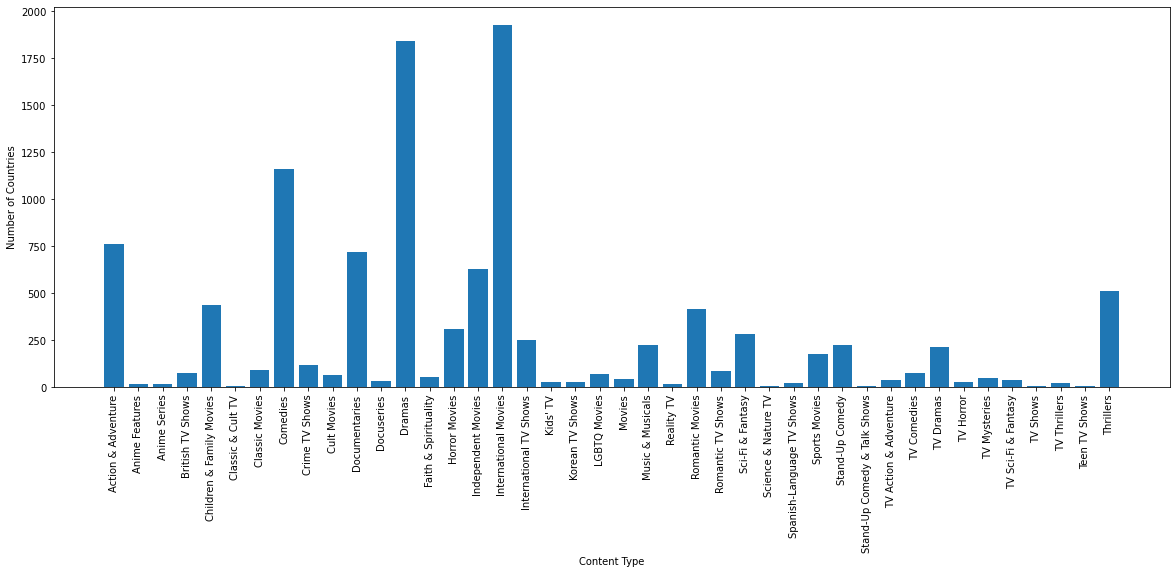

42


In [55]:
plt.figure(figsize=(20,7))
plt.ylabel("Number of Countries")
plt.xlabel("Content Type")
plt.xticks(rotation=90)
plt.bar(netflix_groupby_genre_countries.index, netflix_groupby_genre_countries['Country'])
plt.show()
print (len(netflix_groupby_genre_countries.index))

## Top 10 content types and number of countries produced them

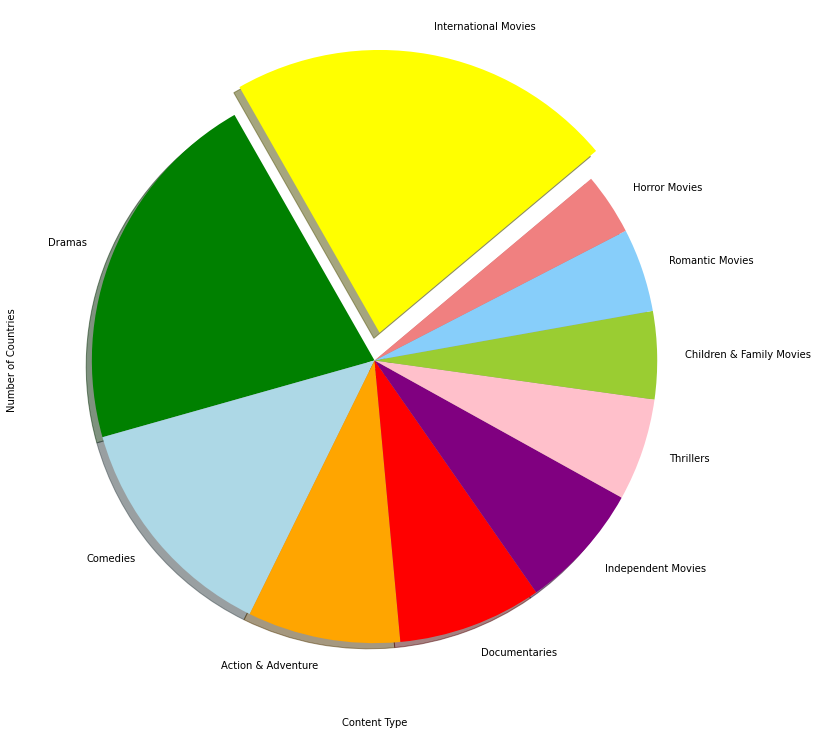

In [56]:
netflix_groupby_genre_countries_sorted = netflix_groupby_genre_countries.sort_values ('Country', ascending=False)
netflix_groupby_genre_countries_sorted_top10 = netflix_groupby_genre_countries_sorted.iloc[:10]

plt.figure(figsize=(13,13))
plt.ylabel("Number of Countries")
plt.xlabel("Content Type")
colors = ["yellow","green","lightblue","orange","red","purple","pink","yellowgreen","lightskyblue","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0)
plt.pie(netflix_groupby_genre_countries_sorted_top10['Country'], explode=explode, colors=colors,
        labels=netflix_groupby_genre_countries_sorted_top10.index,shadow=True,startangle=40)

plt.show()


In [92]:
### Top 20 tiltes based on the revenue 
netflix_directors_casts = netflix_titles_casts.merge (netflix_titles_directors, left_on='Titles',right_on='Titles')
netflix_titles_costs = netflix_titles.filter(['show_id','title','Budget','Revenue'], axis=1)

netflix_directors_casts_revenue = netflix_directors_casts.merge (netflix_titles_costs, left_on='Titles',right_on='show_id')
netflix_groupby_directors_casts_costs = netflix_directors_casts_revenue.groupby(['Cast','Director'])['Revenue'].max().reset_index()
#netflix_groupby_directors_casts.sort_values ('Titles', ascending=False)
TopPairDirectorCast = netflix_groupby_directors_casts_costs.sort_values(['Revenue'], ascending=False)
TopPairDirectorCast.head (10)

,Cast,Director,Revenue
4780,Chris Pratt,Anthony Russo,2046239637
22416,Scarlett Johansson,Anthony Russo,2046239637
2026,Anthony Mackie,Joe Russo,2046239637
2024,Anthony Mackie,Anthony Russo,2046239637
11270,Jeremy Renner,Anthony Russo,2046239637
21162,Robert Downey Jr.,Joe Russo,2046239637
21159,Robert Downey Jr.,Anthony Russo,2046239637
22553,Sebastian Stan,Anthony Russo,2046239637
22554,Sebastian Stan,Joe Russo,2046239637
11271,Jeremy Renner,Joe Russo,2046239637


In [141]:
netflix_titles_type_years = pd.DataFrame (netflix_titles.groupby(['type','Netflix release year'])['show_id'].count ())
netflix_titles_type_years.index.values

array([('Movie', 1943), ('Movie', 1944), ('Movie', 1945), ('Movie', 1946),
       ('Movie', 1954), ('Movie', 1955), ('Movie', 1956), ('Movie', 1958),
       ('Movie', 1960), ('Movie', 1962), ('Movie', 1964), ('Movie', 1965),
       ('Movie', 1966), ('Movie', 1967), ('Movie', 1968), ('Movie', 1969),
       ('Movie', 1970), ('Movie', 1971), ('Movie', 1972), ('Movie', 1973),
       ('Movie', 1974), ('Movie', 1975), ('Movie', 1976), ('Movie', 1977),
       ('Movie', 1978), ('Movie', 1979), ('Movie', 1980), ('Movie', 1981),
       ('Movie', 1982), ('Movie', 1983), ('Movie', 1984), ('Movie', 1985),
       ('Movie', 1986), ('Movie', 1987), ('Movie', 1988), ('Movie', 1989),
       ('Movie', 1990), ('Movie', 1991), ('Movie', 1992), ('Movie', 1993),
       ('Movie', 1994), ('Movie', 1995), ('Movie', 1996), ('Movie', 1997),
       ('Movie', 1998), ('Movie', 1999), ('Movie', 2000), ('Movie', 2001),
       ('Movie', 2002), ('Movie', 2003), ('Movie', 2004), ('Movie', 2005),
       ('Movie', 2006), (

In [129]:
"""
plt.plot(
         , netflix_titles_type_years.loc[netflix_titles_type_years['type'] == 'Movie','show_id'])

plt.plot(netflix_titles_type_years.loc[netflix_titles_type_years['type'] == 'TV Show','Netflix release year']
         , netflix_titles_type_years.loc[netflix_titles_type_years['type'] == 'TV Show','show_id'])
plt.show()
"""

temp = netflix_titles_type_years.loc[netflix_titles_type_years["type"] == 'Movie',['Netflix release year']]

KeyError: 'type'